In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import tensorflow as tf

C:\Users\ChristiaanMeijer\anaconda3\envs\robot\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ChristiaanMeijer\anaconda3\envs\robot\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ChristiaanMeijer\anaconda3\envs\robot\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load validation set in tensorflow format

In [2]:
def load_dataset(path):
    data = pd.read_pickle(path)
    n_features = data['clip_features'][0].shape[-1]
    class_names = data['y'].unique()
    y = np.array([np.where(class_names == e)[0][0] for e in data['y']])
    x = np.concatenate(data['clip_features'].to_numpy())
    print(f'Loaded {len(x)} instances from {path}.')
    print(f'X shape {x.shape} and y shape {y.shape} with labels:\n{data["y"].value_counts()}.')
    train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(16)
    return train_ds, class_names, n_features


validation_ds, class_names, n_features = load_dataset('../robot_or_brain_combined_data/validation.pk')


Loaded 750 instances from ../robot_or_brain_combined_data/validation.pk.
X shape (750, 512) and y shape (750,) with labels:
None of the above                  267
Acting or Performing machine       168
Collaborative or Interactive AI    109
Thinking machine                    94
Complex AI                          87
Mysterious AI                       13
Superior human                       8
Learning or recognition machine      4
Name: y, dtype: int64.


In [3]:
class_list = class_names

In [4]:
trues = [class_list[int(y)] for _x, y in validation_ds.unbatch()]

### Print class counts for each split

In [5]:
df([y for y in trues]).value_counts()

None of the above                  267
Acting or Performing machine       168
Collaborative or Interactive AI    109
Thinking machine                    94
Complex AI                          87
Mysterious AI                       13
Superior human                       8
Learning or recognition machine      4
dtype: int64

Some of these counts are horrible. The number of examples in 'Learning or recognition machine', 'Superior human' and 'Mysterious AI' are really too small. Also, the 'None of the above' class is very large, although that's not really a problem.

### Load our trained model

In [6]:
import tensorflow as tf

# model = tf.keras.models.load_model('./fine_tuned_model_3m6herki')
# model = tf.keras.models.load_model('./fine_tuned_model_3f0vzk68')
# model = tf.keras.models.load_model('./fine_tuned_model_qdesgan9')
# model = tf.keras.models.load_model('./clip_features_model_kuw3ehqp')
model = tf.keras.models.load_model('./clip_features_model_kf5cnvvi')

### Make predictions

In [7]:
logits = model.predict(validation_ds)
predicted = [class_list[v] for v in np.argmax(logits, 1)]
from pandas import DataFrame as df

print(df(predicted).value_counts())
print(df(trues).value_counts())

47/47 [==============================] - 0s 3ms/step
None of the above                  367
Acting or Performing machine       107
Thinking machine                    94
Collaborative or Interactive AI     89
Complex AI                          80
Superior human                      10
Mysterious AI                        3
dtype: int64
None of the above                  267
Acting or Performing machine       168
Collaborative or Interactive AI    109
Thinking machine                    94
Complex AI                          87
Mysterious AI                       13
Superior human                       8
Learning or recognition machine      4
dtype: int64


### Performance metrics for CLIP features based classifier

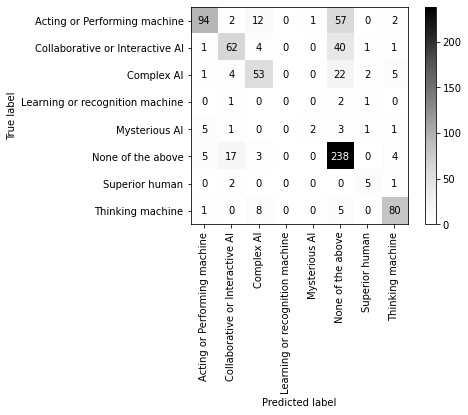

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion = confusion_matrix(trues, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_list)
_ = disp.plot(cmap='Greys', xticks_rotation='vertical')


In [9]:
from utils import display_performance_metrics

display_performance_metrics(trues, predicted, list(class_list))


C:\Users\ChristiaanMeijer\anaconda3\envs\robot\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,recall,precision,f1
Acting or Performing machine,0.56,0.88,0.68
Collaborative or Interactive AI,0.57,0.70,0.63
Complex AI,0.61,0.66,0.63
Learning or recognition machine,0.00,0.00,0.00
Mysterious AI,0.15,0.67,0.25
None of the above,0.89,0.65,0.75
Superior human,0.62,0.50,0.56
Thinking machine,0.85,0.85,0.85


,score
accuracy,0.71
krippendorff alpha,0.61
